In [1]:
import os 

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome')
    train_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/train.csv'
    test_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/test.csv'
    IN_COLAB = True
except:
    os.chdir(r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\Connectome Projekt\Connectome')
    train_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\train.csv'
    test_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\test.csv'
    IN_COLAB = False

!pip install .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing /content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=29178 sha256=60bea63b035ca1c06894d33961b61adee202bcbf6f5cc785258cfdf81830467f
  Stored in directory: /tmp/pip-ephem-wheel-cache-75nu_doy/wheels/33/78/f1/218471f49448b8e9df2af6ab9b92633a6fe2826c87471eba83
Successfully built src
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Unins

### Importing Libraries

In [51]:
!pip install bayesian-optimization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from bayes_opt import BayesianOptimization
from typing import Union

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import scipy.stats
import src.preprocessing.data_loader as dtl
from math import sqrt
from datetime import date

plt.style.use("ggplot")
%matplotlib inline

### Loading and Transforming Data

In [3]:
%%time
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

CPU times: user 21.9 s, sys: 1.55 s, total: 23.5 s
Wall time: 25.9 s


In [4]:
y, X = dtl.preprocess_data(train)
X = X.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
y_test, X_test = dtl.preprocess_data(test)
X_test = X_test.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
del train, test

### Baseline Model (XGB Untuned Classifier)

In [5]:
%%time
lgb_baseline = lgb.LGBMClassifier(tree_method='gpu_hist')
lgb_baseline.fit(X,y)

CPU times: user 4min 11s, sys: 5.23 s, total: 4min 16s
Wall time: 1min 17s


In [6]:
lgb_baseline

LGBMClassifier(tree_method='gpu_hist')

Text(0, 0.5, 'Feature Importance Score')

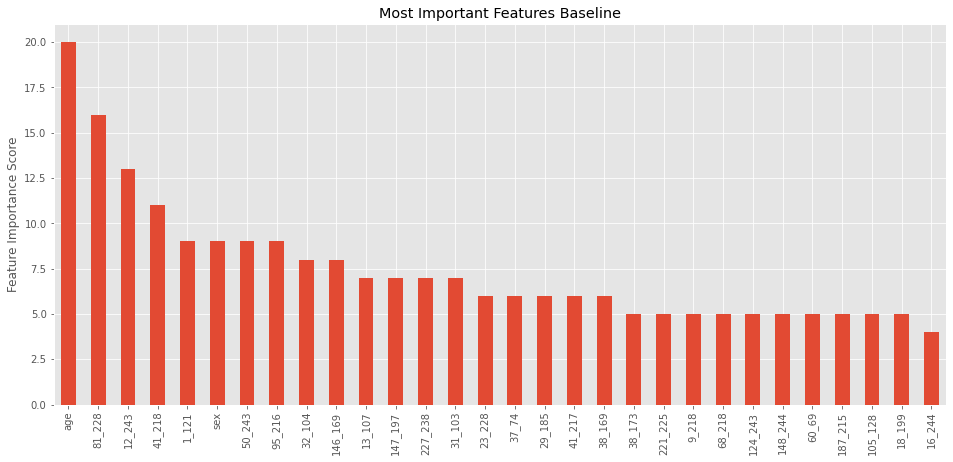

In [7]:
features = list(X.columns)
feat_imp = pd.Series(lgb_baseline.feature_importances_, features).sort_values(ascending=False)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(7)
feat_imp[0:30].plot(kind='bar', title='Most Important Features Baseline')
plt.ylabel('Feature Importance Score')


In [8]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_baseline.score(X_test, y_test)), "\n")
pred = lgb_baseline.predict(X_test)
print("Classification Report - Baseline [Test]")
print(classification_report(y_test, pred))
del lgb_baseline

Accuracy of the GBM on test set: 0.765 

Classification Report - Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.77      0.65      0.71        37
         1.0       0.76      0.85      0.80        48

    accuracy                           0.76        85
   macro avg       0.77      0.75      0.75        85
weighted avg       0.77      0.76      0.76        85



### BO

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=350)
pca.fit(X)
p = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95))

pca = PCA(n_components=p)
X_p = pca.fit_transform(X)
X_test_p = pca.transform(X_test)

In [52]:
from sklearn.model_selection import KFold, RepeatedKFold
from bayes_opt import BayesianOptimization


def bayes_parameter_opt_lgb(X: np.ndarray, 
                            y: np.ndarray, 
                            init_round: int = 15, 
                            opt_round: int = 15, 
                            n_folds: int = 5, 
                            random_seed: int = 6,
                            output_process: bool = False,
                            init_points: int = 15,
                            n_iter: int = 3,
                            sklearn_cv: bool = False, 
                            ranges: dict = None,
                            default_params: dict = None
                            ) -> tuple:
     
    # parameters
    if ranges is None:
        ranges = {
            'learning_rate': (0.001, 0.25),
            'num_leaves': (10, 100),
            'feature_fraction': (0.1, 1.0),
            'max_depth': (5, 40),
            'min_split_gain': (0.001, 0.1),
            'min_child_weight': (1e-4, 0.3),
            'subsample': (0.01, 1.0),
            'num_iterations': (30, 2500)
            } 

    if default_params is None:
            default_params = {
                'application': 'binary',
                'histogram_pool_size': 1000,
                'metric': 'auc', 
                'verbose' : -1,
                'early_stopping_round': 100,
                'max_bin': 60, #default 255
                'n_jobs': -1
                #'n_threads': 2
                        }
    params = default_params.copy()

    def lgb_eval(
        learning_rate,
        num_leaves, 
        feature_fraction, 
        max_depth, 
        min_split_gain, 
        min_child_weight, 
        subsample,
        num_iterations
        ):

        
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['subsample'] = max(min(subsample, 1), 0)
        params['num_iterations'] = int(num_iterations)

        if sklearn_cv:
            kf = RepeatedKFold(n_splits=n_folds, n_repeats=3)
            splits = kf.split(X, y)

        train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
        cv_results = lgb.cv(params, 
                            train_data, 
                            seed=1234,
                            stratified=False,
                            verbose_eval=50,
                            nfold=None if sklearn_cv else n_folds,
                            shuffle=False if sklearn_cv else True,
                            folds=splits if sklearn_cv else None,
                            metrics=['auc'])
        
        return max(cv_results['auc-mean'])
    
    
    
    lgbBO = BayesianOptimization(lgb_eval, ranges, random_state=random_seed)

    lgbBO.maximize(init_points=init_points, n_iter=n_iter)
    
    model_auc=[]
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'], lgbBO.res[pd.Series(model_auc).idxmax()]['params'], default_params

In [50]:
res = bayes_parameter_opt_lgb(X, y, init_round=1, opt_round=2, n_folds=2, init_points=2, n_iter=1)

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | min_sp... | num_it... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.744789 + 0.00750599
[100]	cv_agg's auc: 0.748934 + 0.00926051
[150]	cv_agg's auc: 0.757336 + 0.0132058
[200]	cv_agg's auc: 0.757445 + 0.0129881
[250]	cv_agg's auc: 0.757445 + 0.0129881
|  1        |  0.7583   |  0.9036   |  0.08366  |  33.74    |  0.0126   |  0.01166  |  1.5e+03  |  57.68    |  0.4246   |
[50]	cv_agg's auc: 0.742509 + 0.0107694
[100]	cv_agg's auc: 0.755922 + 0.0140739
[150]	cv_agg's auc: 0.755922 + 0.0140739
|  2        |  0.7571   |  0.4019   |  0.156    |  20.33    |  0.2208   |  0.05229  |  1.46e+03 |  68.08    |  0.9903   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.712067 + 0.00293269
[100]	cv_agg's auc: 0.737451 + 0.00635366
[150]	cv_agg's auc: 0.747266 + 0.00382145
[200]	cv_agg's auc: 0.750051 + 0.00136212
[250]	cv_agg's auc: 0.746067 + 0.00360662
|  3        |  0.7514   |  0.7372   |  0.01767  |  35.58    |  0.1725   |  0.01089  |  1.498e+0 |  54.35    |  0.5982   |


In [46]:
int_params = ['num_iterations', 'max_depth', 'num_leaves']

default_params = {
    'application': 'binary',
    'histogram_pool_size': 1000,
    'metric': 'auc', 
    'verbose' : -1,
    'early_stopping_round': 100,
    'max_bin': 60, #default 255
    'n_jobs': -1
    #'n_threads': 2
}

best_params = res[1]
for key in best_params.keys(): 
    if key in int_params:
        best_params[key] = int(best_params[key])

best_params = {**best_params, **default_params}

In [35]:
best_params

{'application': 'binary',
 'early_stopping_round': 100,
 'feature_fraction': 0.4018670643459963,
 'histogram_pool_size': 1000,
 'learning_rate': 0.15600733861682645,
 'max_depth': 20,
 'metric': 'auc',
 'min_child_weight': 0.22079104369397218,
 'min_split_gain': 0.05228560478792761,
 'n_jobs': 2,
 'num_iterations': 1459,
 'num_leaves': 68,
 'subsample': 0.9903220286596822,
 'verbose': -1}

In [ ]:
EARLY_STOPPING = True
if not EARLY_STOPPING:
    try:
        del best_params['early_stopping_round']
    except:
        pass

lgb_tuned = lgb.LGBMClassifier(**best_params, 
                               tree_method='gpu_hist' 
                               )
X_tr, X_v, y_tr, y_v = train_test_split(X, y, test_size=0.15)
lgb_tuned.fit(X_tr, y_tr, eval_metric='auc', eval_set=(X_v, y_v), verbose=25)

In [ ]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_tuned.score(X_test, y_test)), "\n")
pred = lgb_tuned.predict(X_test)
print("Classification Report - Baseline [Test]")
print(classification_report(y_test, pred))

In [ ]:
def hpo_lgbm(
    X: np.ndarray, 
    y: np.ndarray,
    return_model: bool = False,
    save_model: bool = True,
    **kwargs
    ) -> Union[lgb.sklearn.LGBMClassifier, dict]:
             
    #perform BO based on given parameters
    res = bayes_parameter_opt_lgb(X, y, **kwargs)
    default_params = res[2]
    best_params = res[1]

    #transform some parameters to integer
    int_params = ['num_iterations', 'max_depth', 'num_leaves']
    
    for key in best_params.keys():
        if key in int_params:
            best_params[key] = int(best_params[key])

    best_params = {**best_params, **default_params}


    if return_model:
        lgb_tuned = lgb.LGBMClassifier(
            **best_params,
            tree_method='gpu_hist'
            )
        X_tr, X_v, y_tr, y_v = train_test_split(X, y, 
                                                test_size=0.15)

        lgb_tuned.fit(X_tr, y_tr, 
                      eval_metric='auc', 
                      eval_set=(X_v, y_v), 
                      verbose=25)
        
        #save model before returning if given

        return lgb_tuned

    else:
        return best_params



